In [2]:
import polars as pl

In [3]:
%%time
fuel_type_edf = (
    pl.scan_parquet("../../test_result.parquet/*", low_memory=True)
    .select(["test_result", "test_date", "fuel_type"])
    .filter(pl.col("test_result") == "P")
    .with_columns(
        pl.col("fuel_type")
        .map_dict(
            {"Hybrid Electric (Clean)": "HY", "Electric": "EL"}, default=pl.first()
        )
        .cast(str),
        pl.col("test_date").dt.year().alias("Year"),
    )
    .groupby(["Year", "fuel_type"])
    .agg(pl.col("test_result").count().alias("vehicle_count"))
    .collect(streaming=True)
)

CPU times: user 2min 5s, sys: 8.39 s, total: 2min 14s
Wall time: 30.5 s


In [4]:
fuel_type_df = (
    fuel_type_edf.pivot(
        index="Year",
        columns="fuel_type",
        values="vehicle_count",
        aggregate_function="sum",
        sort_columns=True,
    )
    .fill_null(0)
    .sort(by="Year")
    .to_pandas()
    .set_index("Year")
)

fuel_type_df.head()

,CN,DI,ED,EL,FC,GA,GB,GD,HY,LN,LP,OT,PE,ST
Year,,,,,,,,,,,,,,
2005,11,1258805,0,335,3,20,121,0,25,18,7030,125,4098561,26
2006,61,5438952,0,1699,20,50,481,1,152,53,31308,693,17368825,89
2007,54,5973332,0,2539,36,56,584,1,381,66,32428,1159,17411739,104
2008,56,6448408,0,4660,85,54,682,2,1129,65,32569,2367,17174571,110
2009,58,7008115,0,7980,133,57,733,3,2424,68,31810,4276,17086268,122


Text(0, 0.5, 'Count (million)')

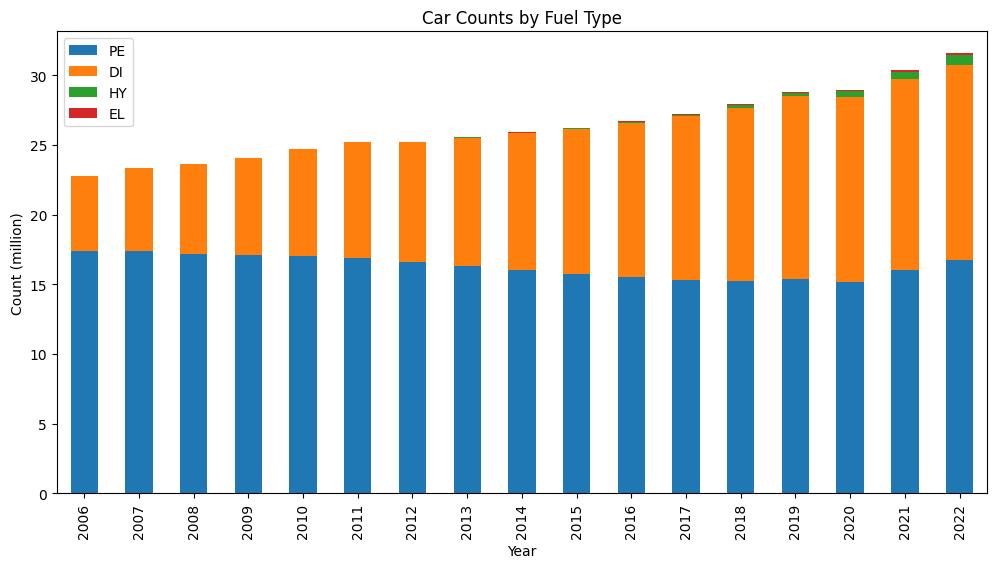

In [5]:
ax = (
    fuel_type_df.loc[2006:, ["PE", "DI", "HY", "EL"]]
    .div(1000000)
    .reset_index()
    .plot.bar(figsize=(12, 6), x="Year", stacked=True, title="Car Counts by Fuel Type")
)
ax.set_ylabel("Count (million)")